In [35]:
import os
import sys
import glob
import itertools

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

%matplotlib inline

## Mondrian Processes

### Various Functions for Mondrian Processes

Visualization...

In [36]:
### VISUALIZE 2D MONDRIAN PROCESS ###
def print_partitions(p, trans_level=1., color='k'):
    if not p[1] and not p[2]: 
        plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
    
    else:
        print_partitions(p[1], trans_level, color)
        print_partitions(p[2], trans_level, color)
        
        
### VISUALIZE 2D POSTERIOR WITH DATA###
def print_posterior(data, samples, trans_level=.05, color='k'):

    plt.figure()
    plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=80, alpha=.5)

    #print all samples
    for sample in samples:
        print_partitions(sample, trans_level, color)

## Flow Cytometry Data

Load AML dataset from [ACDC paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5447237/pdf/btx054.pdf)...

In [37]:
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
PATH = '/Users/enalisnick/Desktop/flow_cyto_data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)

### transform data
data = np.arcsinh((X-1.)/5.)

print table
print X.shape

                        CD45RA  CD133  CD19  CD22  CD11b  CD4  CD8  CD34  \
Basophils                  0.0    0.0    -1   0.0    0.0  0.0 -1.0    -1   
CD4 T cells                0.0    0.0    -1   0.0    0.0  1.0 -1.0    -1   
CD8 T cells                0.0    0.0    -1   0.0    0.0 -1.0  1.0    -1   
CD16- NK cells             0.0    0.0    -1   0.0    0.0  0.0  0.0    -1   
CD16+ NK cells             0.0    0.0    -1   0.0    0.0  0.0  0.0    -1   
CD34+CD38+CD123- HSPCs     0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
CD34+CD38+CD123+ HSPCs     0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
CD34+CD38lo HSCs           0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
Mature B cells             0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Plasma B cells             0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Pre B cells                0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Pro B cells                0.0    0.0     1   0.0    0.0  0.0 -1.0     1   
Monocytes   

## Mondrian Process Generative Model

We apply Mondrian Processes (MPs) to flow cytometry data, using the prior information in the table above to guide the axis-aligned cuts.  Instead of uniformly, we draw the cut proportion from $w \sim \text{Beta}(a_{0}, b_{0})$. 

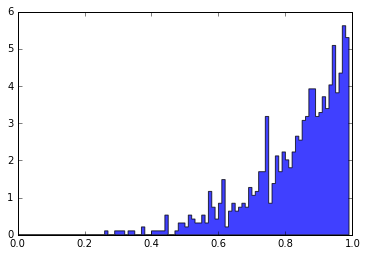

In [38]:
plt.figure()

a0, b0 = 5, 1
beta_samples = np.random.beta(a0, b0, 1000)

n, bins, patches = plt.hist(beta_samples,[x*10**(-2) for x in range(100)], normed=1, histtype='stepfilled')
plt.setp(patches, 'facecolor', 'b', 'alpha', 0.75)

plt.xlim([0,1])
plt.show()

Now let's re-implement the MP sampling function, accounting for the prior information...

In [39]:
def draw_informed_Mondrian_at_t(theta_space, table, priors_dict, cut_history):
    
    if sum(cut_history) == 0 or table.shape[0] == 1 or table.shape[0] == 0:
        return (theta_space, None, None)
    
    low, medium, high = 0.01, 1, 100
    priority_dict = {'-1': low , '0': low, '1': low, 
                   '-1 0': medium, '0 1': medium,
                   '-1 0 1': high, '-1 1':high
    }
    
    types_str = [' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) for d in range(table.shape[1])]
    if set([types_str[d] for d in range(table.shape[1]) if cut_history[d] == 1]).issubset({'0','1','-1'}):
        return (theta_space, None, None)
    
    types = np.array([priority_dict[_] for _ in types_str])
    

    dists = (theta_space[:,1] - theta_space[:,0])* types    
    lin_dim = np.sum(dists)
    
    
    # draw dimension to cut
    dim_probs = ((dists/lin_dim) * np.array(cut_history)) 
    dim_probs /= np.sum(dim_probs)
    d = np.argmax(np.random.multinomial(n=1, pvals=dim_probs))
    #print "make a cut at dim: %d " % d
    cut_history[d] = 0

    prior_type_str = ' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))])
    prior_params = priors_dict[prior_type_str]
    
    # make scaled cut
    x = (theta_space[d,1] - theta_space[d,0]) * np.random.beta(prior_params[0], prior_params[1]) + theta_space[d,0]
    
    idx_table_left = table[table.columns[d]] != 1
    table_left = table.loc[idx_table_left]

    idx_table_right = table[table.columns[d]] != -1
    table_right = table.loc[idx_table_right]
    
    # make lower partition
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x
    M_left = draw_informed_Mondrian_at_t(theta_left, table_left, priors_dict, list(cut_history))
    
    # make upper partition
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_informed_Mondrian_at_t(theta_right, table_right, priors_dict,list(cut_history))
    
    return (theta_space, M_left, M_right)

In [40]:
### SAMPLE MONDRIAN PROCESS WITH PRIOR INFORMATION ###
def draw_informed_Mondrian(theta_space, table, budget=5):
    
    # INFORMATIVE PRIORS
    upper_cut = (5., 1.)
    lower_cut = (1., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (1., 1.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut, '': neutral_cut
                  }
    
    # init dimension mask
    dim_mask = np.ones((theta_space.shape[0],))
    
    # get dims with prior info
    for d in range(dim_mask.shape[0]):
        matching_prior_info = sorted(set(table[table.columns[d]]))
        s = ' '.join([str(int(x)) for x in matching_prior_info])
        if s == '0' or s=='-1' or s=='1': #or s=='-1 0' or s=='0 1' or s=='-1' or s=='1'
            dim_mask[d] = 0. 
            
    #print np.sum(dim_mask)
    
    return draw_informed_Mondrian_at_t(theta_space, table, priors_dict, dim_mask)

## Experiment #1: Subset of Data, All Dimensions

Let's now test out the idea on (a subset of) the data with all dimensions.  

In [41]:
np.random.shuffle(data)
data_5k = data[:5000,:]
N, d = data_5k.shape
print N,d

# rename table header 'HLA-DR' to 'HLADR' to prevent error from '-'
temp_headers = list(table)
temp_headers[29] = "HLADR"
table.columns = temp_headers
print table.columns

'''
### FOR TESTING
data_5k = np.hstack([data[:,5][np.newaxis].T, data[:,6][np.newaxis].T])
np.random.shuffle(data_5k)
data_5k = data_5k[:5000,:]
table = table[['CD4', 'CD8']]
N, d = data_5k.shape
'''

emp_bounds = [(data_5k[:,i].min(), data_5k[:,i].max()) for i in range(d)]

5000 32
Index([u'CD45RA', u'CD133', u'CD19', u'CD22', u'CD11b', u'CD4', u'CD8',
       u'CD34', u'Flt3', u'CD20', u'CXCR4', u'CD235ab', u'CD45', u'CD123',
       u'CD321', u'CD14', u'CD33', u'CD47', u'CD11c', u'CD7', u'CD15', u'CD16',
       u'CD44', u'CD38', u'CD13', u'CD3', u'CD61', u'CD117', u'CD49d',
       u'HLADR', u'CD64', u'CD41'],
      dtype='object')


### Approximate MLE

Let's first calculate an approximate MLE using K-Means.  This will be used to assess MCMC burn in...

In [42]:
mle_K = 20

# run K means (instead of medians)
kmeans = KMeans(n_clusters=mle_K, max_iter=1000, n_jobs=1)
mle_cluster_assignments = kmeans.fit_predict(data_5k)

# get each cluster's bounds
mle_cluster_bounds = get_cluster_bounds(data_5k, mle_cluster_assignments)

#Calculate max. likelihood estimate
log_p_MLE = 0.
for k_idx in range(mle_K):
    k_count = len(np.nonzero(mle_cluster_assignments==k_idx)[0])
    log_p_MLE += k_count * np.sum( [-np.log(mle_cluster_bounds[k_idx][i][1]-mle_cluster_bounds[k_idx][i][0]) for i in range(d)] )
    
print "log prob. MLE: %f" %(log_p_MLE)

log prob. MLE: -106992.234222


### Posterior Inference with MCMC

Now run MCMC to collect posterior samples.  First let's define a cut proposal function...

In [43]:
def Mondrian_Gaussian_perturbation(theta_space, old_sample, stepsize=.5):
    """
    Input: 
    theta_space: a rectangle
    old_sample: partioned theta_space of a mondrian process
    stepsize: gaussian std
    """
    if old_sample[1] == None and old_sample[2] == None:
        return (theta_space, None, None)
    
    # find the dimension and location of first cut in the old_sample
    for _ in range(old_sample[0].shape[0]):
        if old_sample[0][_,1] > old_sample[1][0][_,1]:
            break    
    dim, pos = _, old_sample[1][0][_,1]
    # propose position of new cut
    good_propose = False
    while good_propose == False:
        new_pos = pos + np.random.normal(0,(old_sample[0][dim,1] - old_sample[0][dim,0])*stepsize,1)[0]
        if new_pos < theta_space[dim,1] and new_pos > theta_space[dim,0]:
            good_propose = True
    
    theta_left = np.copy(theta_space)
    theta_left[dim,1] = new_pos
    theta_right = np.copy(theta_space)
    theta_right[dim,0] = new_pos
    
    new_M_left= Mondrian_Gaussian_perturbation(theta_left, old_sample[1], stepsize)
    new_M_right = Mondrian_Gaussian_perturbation(theta_right, old_sample[2], stepsize)
    
    return (theta_space, new_M_left, new_M_right)

Now let's declare a function for log likelihood calculations...

In [45]:
def comp_log_p_sample(theta_space, data):
    if theta_space[1] == None and theta_space[2] == None:
        return 0
    
    # find the dimension and location of first cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    
    dim, pos = _, left_rec[_,1]
    idx_left = data[:,dim] < pos
    idx_right = data[:,dim] >= pos
    log_len_left =  np.log(pos - root_rec[dim,0])
    log_len_right = np.log(root_rec[dim,1] - pos)
    return - idx_left.sum() * log_len_left - idx_right.sum() * log_len_right +\
            comp_log_p_sample(theta_space[1], data[idx_left]) + comp_log_p_sample(theta_space[2], data[idx_right])

Finally, let's run our MCMC iterations...

In [ ]:
import time
import sys

def get_Mondrian_partition_bounds(p):
    if not p[1] and not p[2]: 
        return [[(p[0][i,0], p[0][i,1]) for i in range(d)]]
    else:
        return get_Mondrian_partition_bounds(p[1]) + get_Mondrian_partition_bounds(p[2])

    
n_chains = 10
n_its_per_chain = 10000
burn_in_threshold = log_p_MLE - 10000

samples = []
time_agg = 0.
for chain_idx in xrange(n_chains):
    
    print "Running chain #%d..." %(chain_idx)
    
    # get inital starting sample
    sample = draw_informed_Mondrian(np.array(emp_bounds), table, budget=1.)
    log_p_sample = comp_log_p_sample(sample, data_5k) 
    
    for idx in xrange(n_its_per_chain):    
        start = time.time()
        
        new_sample = Mondrian_Gaussian_perturbation(theta_space=np.array(emp_bounds), old_sample=sample, stepsize=.1)
        log_p_new_sample = comp_log_p_sample(new_sample, data_5k) 
        
        # perform accept-reject step
        if log_p_sample <= log_p_new_sample and np.log(np.random.uniform(low=0, high=1.)) < log_p_new_sample - log_p_sample:
            
            # check if we've burned in or not
            if log_p_new_sample > burn_in_threshold:
                samples.append(sample)
            
            sample = new_sample
            log_p_sample = log_p_new_sample
    
        end = time.time()
        time_agg += (end-start)
        
        if (idx+1) % 250 == 0:
            print "Iteration %d, Samples %d, Avg time per iter. %.4f, log p of current sample %.2f" %(idx+1, len(samples), time_agg/100, log_p_sample)
            time_agg = 0.

print "Number of samples collected: %d" %(len(samples))

Running chain #0...
Iteration 250, Samples 17, Avg time per iter. 0.0116, log p of current sample -14046.83
Iteration 500, Samples 19, Avg time per iter. 0.0116, log p of current sample -12126.80
Iteration 750, Samples 19, Avg time per iter. 0.0102, log p of current sample -12126.80
Iteration 1000, Samples 20, Avg time per iter. 0.0105, log p of current sample -12093.30
Iteration 1250, Samples 21, Avg time per iter. 0.0108, log p of current sample -11504.23
Iteration 1500, Samples 21, Avg time per iter. 0.0113, log p of current sample -11504.23
Iteration 1750, Samples 21, Avg time per iter. 0.0116, log p of current sample -11504.23
Iteration 2000, Samples 22, Avg time per iter. 0.0108, log p of current sample -11425.52
Iteration 2250, Samples 23, Avg time per iter. 0.0110, log p of current sample -11352.58
Iteration 2500, Samples 24, Avg time per iter. 0.0107, log p of current sample -10149.97
Iteration 2750, Samples 24, Avg time per iter. 0.0116, log p of current sample -10149.97
Iter

### Compute Classification Accuracy